In [1]:
p = 90
N = 30
BATCH_SIZE = 24
CIRCLES_SCALER = 1
# CIRCLES_SCALER = BATCH_SIZE * N

In [15]:
import pickle

import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import numpy as np

from collections import defaultdict
from pathlib import Path
from sklearn.metrics.pairwise import pairwise_distances
from tqdm.asyncio import tqdm
from string import Template
from joblib import Parallel, delayed
from descriptor import Desctiptor
des = Desctiptor()

def maximal_independent_set(D, t):
    adj_matrix = np.array(D <= t, dtype=int)
    np.fill_diagonal(adj_matrix, 0)
    G = nx.from_numpy_array(np.array(adj_matrix))
    return nx.maximal_independent_set(G)

def calc_circles(X, radius):
    D = pairwise_distances(X, metric="euclidean")
    # for t in [2**j for j in range(7)]:
    s = maximal_independent_set(D, radius)
    # print(k, t, len(s))
    return len(s)

def get_circles(X, action_idx, threshold_list):
    """並列化されたバージョン - joblibのスレッド並列化を使用（推奨）"""
    return Parallel(n_jobs=-1, backend='threading')(
        delayed(calc_circles)(X, action_idx, t) for t in threshold_list)

def get_circles_process_parallel(X, action_idx, threshold_list):
    """プロセス並列化バージョン（大きなデータセット用）"""
    return Parallel(n_jobs=-1)(delayed(calc_circles)(X, action_idx, t) for t in threshold_list)

def get_circles_sequential(X, action_idx, threshold_list):
    """元のシーケンシャルバージョン（比較用）"""
    return [calc_circles(X, action_idx, t) for t in threshold_list]

# Directory name's template string
dir_template = Template("data_${MODE}_${TRIALS}")
trials_list = [1, 2, 3, 4, 5]
mode_list = ["aggressive", "moderate", "conservative"]
radius_list = np.arange(0, 5.1, 0.1)

In [16]:
# データ構造の詳細調査と修正されたデータ読み込み


def collect_near_optimal_samples(samples_dict, objectives_dict, target_threshold, iter_num):
    """
    指定されたイテレーション数まで、target_thresholdを超えるサンプルを収集する関数
    
    Parameters:
    -----------
    samples_dict : dict
        各イテレーションのサンプルデータ
    objectives_dict : dict  
        各イテレーションの目的値データ
    target_threshold : float
        閾値
    iter_num : int
        処理するイテレーション数
    
    Returns:
    --------
    dict : 各イテレーションまでの累積near-optimalサンプル
    int : 見つかったnear-optimalサンプルの総数
    """
    near_optimal_samples_by_iter = defaultdict(list)
    
    for k in range(1, iter_num + 1):
        # near_optimal_samples_by_iter は各イテレーションまでに見つかったnear-optimal samplesを全て保持
        near_optimal_samples_by_iter[k] = near_optimal_samples_by_iter[k-1].copy()
        for sample, obj in zip(samples_dict[k], objectives_dict[k]):
            if obj >= target_threshold:
                near_optimal_samples_by_iter[k].append(sample)
    
    return near_optimal_samples_by_iter

def circles_by_radius(X, radius_list):
    return [calc_circles(X, r) for r in radius_list]

def all_circles(sample_path, objective_path, target_threshold, N):

    with open(sample_path, 'rb') as f:
        samples_dict = pickle.load(f)

    with open(objective_path, 'rb') as f:
        objectives_dict = pickle.load(f)


    # function = Descriptor()
    near_optimal_samples_by_iter = defaultdict(list)
    # kを1から10まで変化させ、target_thresholdを超えたサンプルを

    # 関数を使用
    near_optimal_samples_by_iter = collect_near_optimal_samples(
        samples_dict, objectives_dict, target_threshold, N
    )
    circles = circles_by_radius(near_optimal_samples_by_iter[N], radius_list)
    return circles

def all_max_objective(sample_path, objective_path, N):

    with open(sample_path, 'rb') as f:
        samples_dict = pickle.load(f)

    with open(objective_path, 'rb') as f:
        objectives_dict = pickle.load(f)

    max_objective_list = [max(objectives_dict[1])]
    for k in range(1, N + 1):
        # print(max_objective_list, max(objectives_dict[k]))
        max_objective_list.append(max(max_objective_list[-1], max(objectives_dict[k])))
    return max_objective_list

# target_threshold は function.y の90パーセンタイルに対応
target_threshold = np.percentile(des.y, p)
print(f"Target threshold for {p}% percentile: {target_threshold}")

Target threshold for 90% percentile: 1.1465392917


In [17]:
# まず、1つのイテレーションのデータ構造を詳しく調べる
# mode = "conservative"
trial_list = [1, 2, 3, 4, 5]
mode_list = ["random", "conservative", "moderate", "aggressive", "physbo"]
mode_to_circles = defaultdict(list)
for mode in mode_list:
    for trial in trial_list:
        data_dir = dir_template.substitute(MODE=mode, TRIALS=trial)
        sample_path = Path(data_dir) / "sample_by_iter.pkl"
        objective_path = Path(data_dir) / "objective_by_iter.pkl"
        circles = all_circles(sample_path, objective_path, target_threshold, N)
        # CIRCLES_SCALER = max(circles)
        mode_to_circles[mode].append([c / CIRCLES_SCALER for c in circles])


[1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7]


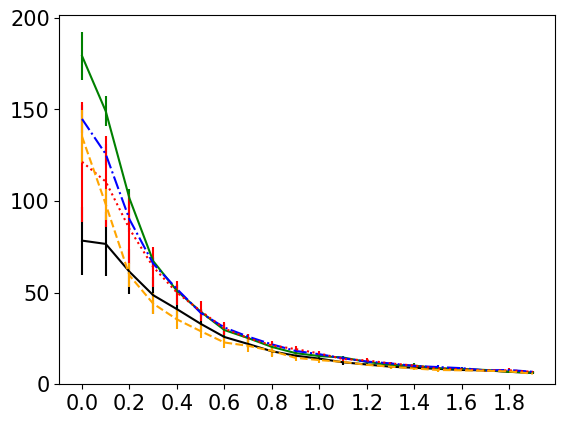

In [30]:
import matplotlib.pyplot as plt

mode_to_style = {
    "random": "-",
    "aggressive": ":",
    "moderate": "-.",
    "conservative": "-",
    "physbo": "--",
}

mode_to_color = {
    "random": "black",
    "aggressive": "red",
    "moderate": "blue",
    "conservative": "green",
    "physbo": "orange",
}

fig, ax = plt.subplots()
tmp = 0
for mode in mode_list:
    mean_circles = np.mean(np.array(mode_to_circles[mode]), axis=0)
    std_circles = np.std(np.array(mode_to_circles[mode]), axis=0)
    tmp = max(mean_circles[0], tmp)
    ax.errorbar(radius_list[:20], mean_circles[:20], yerr=std_circles[:20], label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
    # ax.fill_between(radius_list, mean_circles-std_circles, mean_circles+std_circles, color=mode_to_color[mode], alpha=.3)
    # ax.plot(radius_list, mean_circles, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
# ax.set_xlabel("Radius", fontsize=15)
# ax.set_ylabel("Number of circles", fontsize=15)
# ax.set_title(f"Comparison of circles (target threshold: {target_threshold:.2f})")
# ax.set_ylim(0, 10 * int(tmp / 10) + 20)
ax.set_ylim(0)
# ax.set_xlim(-0.1)
ticks = radius_list[:20]
print(ticks[0:-1:2] + [ticks[-1]])
ax.set_xticks(ticks[0:-1:2])
# ax.set_yticks([1] + [5, 10, 15, 20, 25, 30, 35, 40])
# plt.legend(fontsize=20, frameon=False)
plt.savefig(f"figures/circles_comparison_{p}percentile_{N}iterations_normalized.pdf")

NameError: name 'mode_to_circles' is not defined

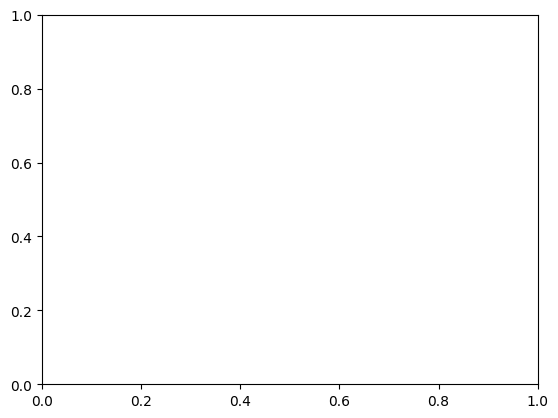

In [5]:
fig, ax = plt.subplots()
tmp = 0
for mode in mode_list:
    mean_circles = np.mean(np.array(mode_to_circles[mode]), axis=0)
    std_circles = np.std(np.array(mode_to_circles[mode]), axis=0)
    tmp = max(mean_circles[0], tmp)
    ax.errorbar(radius_list, mean_circles, yerr=std_circles, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
ax.set_xlabel("Radius", fontsize=15)
ax.set_ylabel("Number of circles", fontsize=15)
ax.set_title(f"Comparison of circles (target threshold: {target_threshold:.2f})")
# ax.set_ylim(0, 10 * int(tmp / 10) + 20)
# plt.legend(fontsize=25, frameon=False)
ax.set_yscale("log")
# ax.set_ylim(1)
# ax.set_yticks([1, 10])
plt.savefig(f"figures/circles_comparison_{p}percentile_{N}iterations_log_normalized.pdf")

In [18]:
mode_to_objectives = defaultdict(list)
mode_to_regrets = defaultdict(list)
for mode in mode_list:
    for trial in trial_list:
        data_dir = dir_template.substitute(MODE=mode, TRIALS=trial)
        sample_path = Path(data_dir) / "sample_by_iter.pkl"
        objective_path = Path(data_dir) / "objective_by_iter.pkl"
        objectives = all_max_objective(sample_path, objective_path, N)
        mode_to_objectives[mode].append(objectives)
        mode_to_regrets[mode].append([des.get_regret(obj) for obj in objectives])

(0.0, 2.019825341326415)

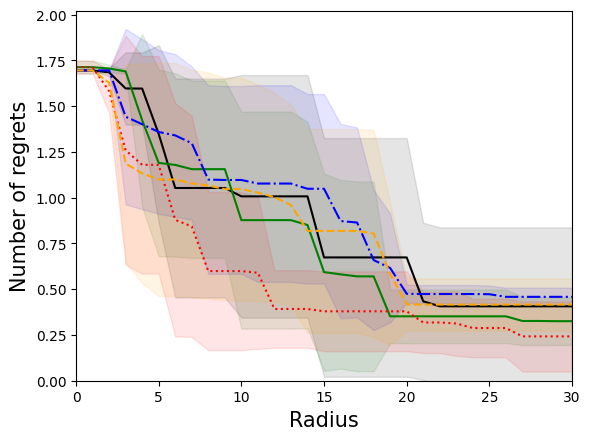

In [16]:
fig, ax = plt.subplots()
for mode in mode_list:
    mean_regrets = np.mean(np.array(mode_to_regrets[mode]), axis=0)
    std_regrets = np.std(np.array(mode_to_regrets[mode]), axis=0)
    # ax.errorbar(np.arange(len(mean_regrets)), mean_regrets, yerr=std_regrets, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
    ax.plot(np.arange(len(mean_regrets)), mean_regrets, label=mode, linestyle=mode_to_style[mode], color=mode_to_color[mode])
    ax.fill_between(np.arange(len(mean_regrets)), mean_regrets - std_regrets, mean_regrets + std_regrets, alpha=0.1, color=mode_to_color[mode])
ax.set_xlabel("Radius", fontsize=15)
ax.set_ylabel("Number of regrets", fontsize=15)
# ax.set_title(f"target threshold: {target_threshold:.2f} / regret: {des.get_regret(target_threshold):.2f})")
# ax.set_ylim(0, 180)
ax.set_xlim(0, N)
ax.set_ylim(0)
# Move legend outside the plot
# ax.legend(fontsize=25, frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
# plt.savefig(f"figures/simple_regret.pdf")

In [19]:
# integral under the curve
np.trapz(mean_circles, radius_list)
trapz_dict = defaultdict(list)
for mode in mode_list:
    mode_circles = np.array(mode_to_circles[mode])
    for circles in mode_circles:
        trapz_dict[mode].append(np.trapz(circles, radius_list))
for mode in mode_list:
    # 少数第二位まで
    print(f"{mode} & {np.mean(trapz_dict[mode])} ± {np.std(trapz_dict[mode])}")

random & 0.39201388888888894 ± 0.049223327364067176
conservative & 0.55 ± 0.019651673506471096
moderate & 0.5206944444444445 ± 0.020475632913535935
aggressive & 0.496875 ± 0.061269916766854594
physbo & 0.4134722222222223 ± 0.028704506410520365


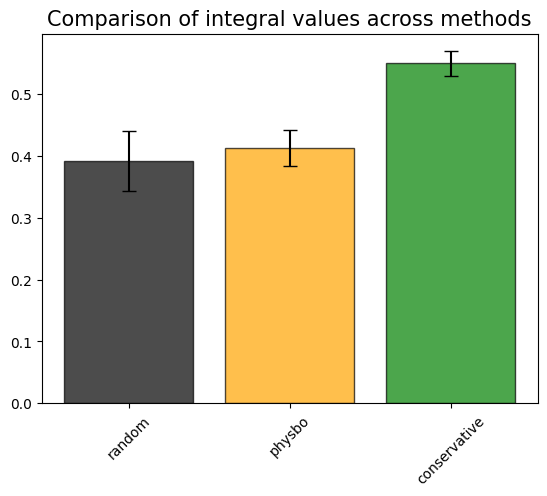

In [20]:
# mode ごとに積分値の平均と分散を棒グラフにする
modes = list(trapz_dict.keys())
modes = ["random", "physbo", "conservative"]
means = [np.mean(trapz_dict[mode]) for mode in modes]
stds = [np.std(trapz_dict[mode]) for mode in modes]

fig, ax = plt.subplots()
bars = ax.bar(modes, means, yerr=stds, capsize=5, 
              color=[mode_to_color[mode] for mode in modes],
              alpha=0.7, edgecolor='black')

# ax.set_xlabel("Method", fontsize=15)
# ax.set_ylabel("Integral under the curve", fontsize=15)
ax.set_title("Comparison of integral values across methods", fontsize=15)
plt.xticks(rotation=45)
# plt.tight_layout()
plt.savefig("figures/auc_selected.pdf")